# Illustration of DIVAnd

The aim of this notebook is to choose the location of 100 observations to
optimally reconstruct the provided sea surface temperature anomaly using DIVAnd.
We use the Reynolds et al. 2002 [OI SST](https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) for the month January and remove the zonal average. This is assumed to be the "true field" in the followed.

1. You should work in groups. Choose a group name and adapt the `groupname` accordingly
2. Please change only the marked code (after "Your turn !" and before "Do not make any change below")
3. You choose:
     * the location of 100 observations (the vectors `xobs` and `yobs` which corresponds to longitude in degrees East and latitude in degrees North)
     * the correlation length `len`
     * the uncertainty of the observation `epsilon2`
4. You are allowed to guide your choice by using the true field `v` (the target variable)
5. Your results must be reproducible (the locations of the observations are saved in a text file at the end of the notebook)
6. You can submit as many test as you wish, only the best result with lowest root mean square (RMS) error is shown.


First load all modules

In [2]:
using DIVAnd
#using PyPlot
using CairoMakie
using NCDatasets
using Statistics
using Random
using Downloads: download
using Interpolations
using DelimitedFiles

Download the data file if necessary

In [3]:
filename = "sst.ltm.1961-1990.nc"
if !isfile(filename)
    download("https://dox.ulg.ac.be/index.php/s/ptfCNIWGfJ247Gj/download",filename);
end

Load the data

In [4]:
ds = NCDataset(filename)
vfull = reverse(nomissing(ds["sst"][:,:,1],NaN),dims=2)
lon = ds["lon"][:]
lat = reverse(ds["lat"][:])
close(ds);

The array `mask` is 1 on sea and 0 on land

In [5]:
mask = isfinite.(vfull);

Remove the zonal average

In [6]:
v0 = copy(vfull)
v0[.!mask] .= 0
v = vfull .- sum(v0,dims=1) ./ sum(mask,dims=1)
sz  = size(v)
xi,yi =  DIVAnd.ndgrid(lon,lat);

The scale factors (inverse of the resolution)

In [7]:
pm = ones(sz) ./ ((xi[2,1]-xi[1,1]) .* cosd.(yi));
pn = ones(sz) / (yi[1,2]-yi[1,1]);

Number of observations

In [8]:
nobs = 100

100

Noise on observations [°C]

In [9]:
noise = 0.5

0.5

## Your turn !

You can change the following code and variables

In [10]:
# your group name (better use only ASCII symbols)
groupname = "Just-a-test"
# Correlation length in arc degrees (1° ~ 111 km)
len = 20
# Uncertainty of the observation [adimensional]
epsilon2 = 0.001
# Choose 100 random location (only sea points)
# Is there a better way?
indexobs = shuffle(findall(mask[:] .== 1))[1:nobs];
xobs = xi[indexobs];
yobs = yi[indexobs];

## Do not make any change below

Extract the pseudo-observations

In [11]:
xobs = mod.(xobs,360)
itp = interpolate((lon,lat), v, Gridded(Constant()))
vobs = itp.(xobs,yobs);

Add some noise

In [12]:
Random.seed!(42)
vobs_perturbed = vobs + noise * randn(nobs);

Make the analysis

In [13]:
vi,s = DIVAndrun(
    mask,(pm,pn),(xi,yi),(xobs,yobs),
    vobs_perturbed,
    len,epsilon2
);

Plot the results

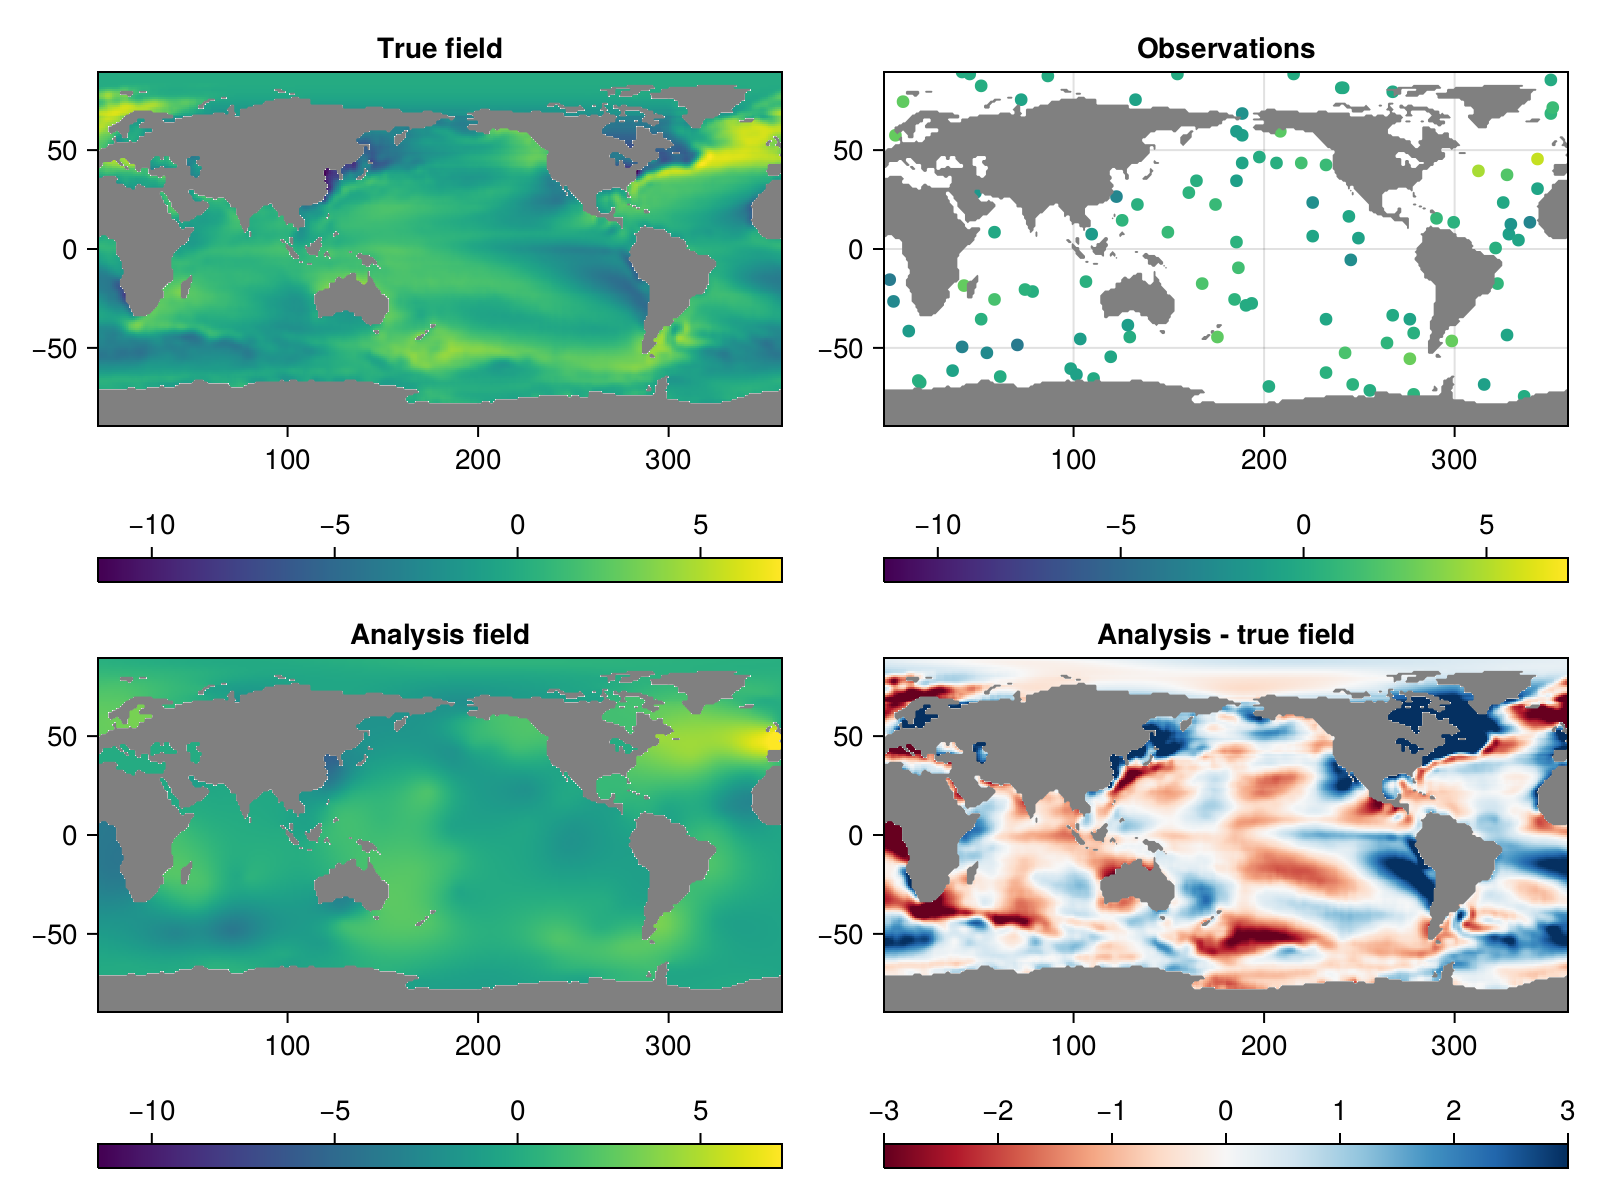

In [48]:
fig = Figure(size = (800, 600))
function map!(ax,gridposition,title; cl = extrema(filter(isfinite,v)))
    xlims!(ax,extrema(lon))
    ylims!(ax,extrema(lat))
    ax.title[] = title
    contourf!(gridposition,xi[:,1],yi[1,:],mask,levels = [0,.5],colormap = [:grey])
end
cl = extrema(filter(isfinite,v))
ax, hm = heatmap(fig[1,1],xi[:,1],yi[1,:],v,colorrange = cl)
map!(ax,fig[1,1],"True field")
Colorbar(fig[2,1],hm, vertical = false)

ax, sc = scatter(fig[1,2],xi[indexobs],yi[indexobs],color = vobs,colorrange = cl)
map!(ax,fig[1,2],"Observations")
Colorbar(fig[2,2],sc, vertical = false)

ax, hm = heatmap(fig[3,1],xi[:,1],yi[1,:],vi,colorrange = cl)
map!(ax,fig[3,1],"Analysis field")
Colorbar(fig[4,1],hm, vertical = false)

ax, hm = heatmap(fig[3,2],xi[:,1],yi[1,:],vi - v,colorrange = (-3,3),colormap = :RdBu)
map!(ax,fig[3,2],"Analysis - true field")
Colorbar(fig[4,2],hm, vertical = false)

fig

RMS difference between analysis and true field

In [49]:
RMS_difference = sqrt(mean(filter(isfinite,(vi - v).^2)))

1.5359108034623787

A function to submit the RMS error to score board:
http://data-assimilation.net/scores/?game=DIVAnd2024

In [51]:
function submit_results(groupname,rms_velocity)
    function myescape(str)
        for (s1,s2) in Dict("{" => "%7B", "}" => "%7D", "\"" => "%22", " " => "%20")
            str = replace(str,s1 => s2)
        end
        return str
    end
    myjson(data) = "{" * join(["\"$k\":$(string(v))" for (k,v) in data],",") * "}"
    game = "DIVAnd2024"

    data_dict = Dict()
    #=
    data = JSON.json(data_dict)
    groupname_esc = URIParser.escape(groupname)
    data_esc = URIParser.escape(data)
    =#
    data = myjson(data_dict)
    groupname_esc = myescape(groupname)
    data_esc = myescape(data)
    baseurl = "http://data-assimilation.net/scores"
    URL = "$(baseurl)/new?game=$(game)&name=$(groupname_esc)&value=$(rms_velocity)&data=$(data_esc)"
    rm(download(URL))
    println("Check scores at: $(baseurl)/?game=$(game)\n")
end

submit_results (generic function with 1 method)

In [52]:
submit_results(groupname,RMS_difference)

Check scores at: http://data-assimilation.net/scores/?game=DIVAnd2024



In [50]:
filename = "positions-rms-RMS-$RMS_difference-len-$len-epsilon2-$epsilon2.txt"
writedlm(filename,[xobs  yobs])